## First Step

First we need to generate the UWB signal. We will use the following parameters:

- Bandwidth: 3.5GHz
- Center frequency: 4 GHz
- Pulse duration: 1 ns
- Sampling frequency: 7s/ns
- Amplitude: 1
- Noise level: 0.02
- Signal seed: 42
- Signal type: UWB
- Signal shape: Gaussian


UWB Pulse Formulas, powered by [scipy.signal.gausspulse](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.gausspulse.html):
$$
\text{UWB}(t) = e^{-at^2}e^{j2\pi f_c t} \\
\text{ref} = 10^{\frac{\text{bwr}}{20}}\\
\text{bw} = \frac{\text{Bandwidth}}{f_c}\\
a = \frac{-(\pi f_c * \text{bw})^2}{\log(\text{ref})}\\
$$

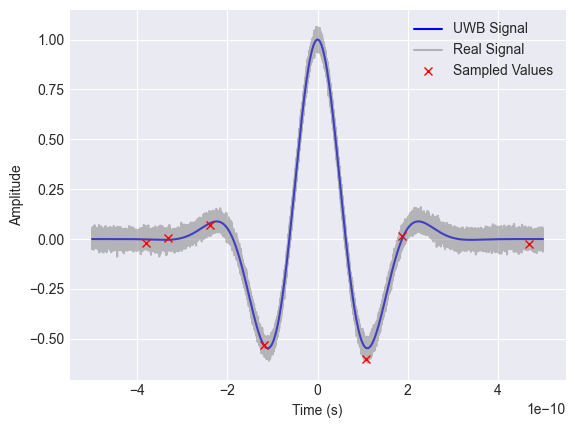

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from matplotlib import style

style.use('seaborn-v0_8-darkgrid')


def UWB_generate(bandwidth=3.5e9, center_freq=4e9,  duration=1e-9, pulse_amplitude=1, sample_rate=1e14, noise_amplitude=0.02):
    """
    Generate a UWB Gaussian pulse
    :param bandwidth: Bandwidth of the pulse
    :param center_freq: Center frequency of the pulse
    :param duration: Duration of the pulse
    :param pulse_width: Width of the pulse
    :param pulse_amplitude: Amplitude of the pulse
    :param sample_rate: Sample rate of the pulse
    :return: Pulse
    """
    
    t = np.linspace(-duration/2, duration/2, int(duration * sample_rate))
    uwb_signal = pulse_amplitude * signal.gausspulse(t, fc=center_freq, bw=(bandwidth / center_freq))
    
    spectrum = np.fft.fft(uwb_signal)
    frequencies = np.fft.fftfreq(len(uwb_signal), d=1/sample_rate)
    
    amplitude_spectrum = np.abs(spectrum)
    phase_spectrum = np.angle(spectrum)
    
    real_signal = uwb_signal + np.random.normal(0, noise_amplitude, len(uwb_signal)) * pulse_amplitude
    
    # sample from real signal, get random 7 samples
    sample_indices = np.random.randint(0, len(real_signal), 7)
    sample_values = real_signal[sample_indices]
    sample_times = t[sample_indices]
    
    return uwb_signal, t, spectrum, frequencies, amplitude_spectrum, phase_spectrum, real_signal, sample_values, sample_times

uwb_signal, t, spectrum, frequencies, amplitude_spectrum, phase_spectrum, real_signal, sample_values, sample_times = UWB_generate()
plt.figure()
plt.plot(t, uwb_signal, color='blue', alpha=1, label='UWB Signal')
plt.plot(t, real_signal, color='gray', alpha=0.5, label='Real Signal')
plt.plot(sample_times, sample_values, 'rx', label='Sampled Values')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(visible=True)
plt.legend()
plt.show()
    

Error: 0.8330620972036474
Error: 0.8330620974400808
Error: 0.8330620976765137
Error: 0.8330620979129469
Error: 0.8330620981493809
Error: 0.8330620983858139
Error: 0.833062098622247
Error: 0.8330620988586802
Error: 0.8330620990951134
Error: 0.8330620993315462
Error: 0.8330620995679794
Error: 0.8330620998044123
Error: 0.8330621000408455
Error: 0.8330621002772787
Error: 0.8330621005137114
Error: 0.8330621007501444
Error: 0.8330621009865774
Error: 0.8330621012230105
Error: 0.8330621014594434
Error: 0.8330621016958767
Error: 0.8330621019323097
Error: 0.8330621021687439
Error: 0.8330621024051768
Error: 0.8330621026416102
Error: 0.833062102878043
Error: 0.8330621031144763
Error: 0.8330621033509091
Error: 0.8330621035873426
Error: 0.8330621038237754
Error: 0.8330621040602083
Error: 0.8330621042966417
Error: 0.8330621045330745
Error: 0.8330621047695078
Error: 0.8330621050059406
Error: 0.8330621052423732
Error: 0.8330621054788067
Error: 0.8330621057152396
Error: 0.8330621059516727
Error: 0.83306

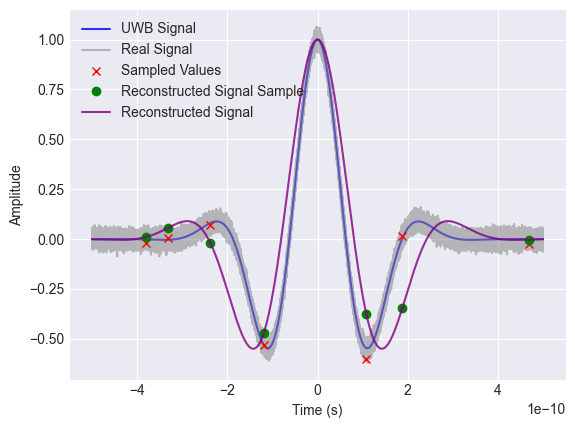

In [6]:
def UWB_FRI_reconstruct(sample_values, sample_times, learning_rate=1):
    """
    Reconstruct the UWB signal from the samples
    :param sample_values: Sampled values
    :param sample_times: Sampled times
    :return: Reconstructed signal
    """
    
    while True:
        center_freq = np.random.uniform(1e9, 8e9)
        bandwidth = np.random.uniform(1e9, 8e9)
        if center_freq - bandwidth / 2 > 0:
            break
    
    t = sample_times
    reconstructed_signal = signal.gausspulse(t, fc=center_freq, bw=(bandwidth / center_freq))
    
    # using gradient descent to minimize the error
    for i in range(1000):
        error = np.sum(np.abs(reconstructed_signal - sample_values))
        if error < 1e-12:
            break
        
        print(f'Error: {error}')
        
        center_freq_gradient = np.sum((reconstructed_signal - sample_values) * signal.gausspulse(t, fc=center_freq, bw=(bandwidth / center_freq), retquad=True)[1])
        bandwidth_gradient = np.sum((reconstructed_signal - sample_values) * signal.gausspulse(t, fc=center_freq, bw=(bandwidth / center_freq), retquad=True)[0])
        
        center_freq -= learning_rate * center_freq_gradient
        bandwidth -= learning_rate * bandwidth_gradient
        
        reconstructed_signal = signal.gausspulse(t, fc=center_freq, bw=(bandwidth / center_freq))
    
    return reconstructed_signal, center_freq, bandwidth

reconstructed_signal_sample, center_freq, bandwidth = UWB_FRI_reconstruct(sample_values, sample_times)
reconstructed_signal = signal.gausspulse(t, fc=center_freq, bw=(bandwidth / center_freq))

plt.figure()
plt.plot(t, uwb_signal, color='blue', alpha=0.8, label='UWB Signal')
plt.plot(t, real_signal, color='gray', alpha=0.5, label='Real Signal')
plt.plot(sample_times, sample_values, 'rx', label='Sampled Values')
plt.plot(sample_times, reconstructed_signal_sample, 'go', label='Reconstructed Signal Sample')
plt.plot(t, reconstructed_signal, color='purple', alpha=0.8, label='Reconstructed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(visible=True)
plt.legend()
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from matplotlib import style

style.use('seaborn-v0_8-darkgrid')


def UWB_generate(bandwidth=3.5e9, center_freq=4e9,  duration=1e-9, pulse_amplitude=1, sample_rate=1e14, noise_amplitude=0.02, pulse_timing=0.1e-9):
    """
    Generate a UWB Gaussian pulse
    :param bandwidth: Bandwidth of the pulse
    :param center_freq: Center frequency of the pulse
    :param duration: Duration of the pulse
    :param pulse_width: Width of the pulse
    :param pulse_amplitude: Amplitude of the pulse
    :param sample_rate: Sample rate of the pulse
    :return: Pulse
    """
    
    t = np.linspace(-duration/2, duration/2, int(duration * sample_rate))
    uwb_signal = pulse_amplitude * signal.gausspulse(t, fc=center_freq, bw=(bandwidth / center_freq))
    
    spectrum = np.fft.fft(uwb_signal)
    frequencies = np.fft.fftfreq(len(uwb_signal), d=1/sample_rate)
    
    amplitude_spectrum = np.abs(spectrum)
    phase_spectrum = np.angle(spectrum)
    
    real_signal = uwb_signal + np.random.normal(0, noise_amplitude, len(uwb_signal)) * pulse_amplitude
    
    # sample from real signal, get random 7 samples
    sample_indices = np.random.randint(0, len(real_signal), 7)
    sample_values = real_signal[sample_indices]
    sample_times = t[sample_indices]
    
    return uwb_signal, t, spectrum, frequencies, amplitude_spectrum, phase_spectrum, real_signal, sample_values, sample_times

uwb_signal, t, spectrum, frequencies, amplitude_spectrum, phase_spectrum, real_signal, sample_values, sample_times = UWB_generate()
plt.figure()
plt.plot(t, uwb_signal, color='blue', alpha=1, label='UWB Signal')
plt.plot(t, real_signal, color='gray', alpha=0.5, label='Real Signal')
plt.plot(sample_times, sample_values, 'rx', label='Sampled Values')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(visible=True)
plt.legend()
plt.show()
    